## Environment Setup

In [1]:
!wget https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/code_files/requirements.txt

--2024-07-11 18:40:49--  https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/code_files/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]      24  --.-KB/s    in 0s      

2024-07-11 18:40:49 (57.9 KB/s) - ‘requirements.txt’ saved [24/24]



In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=ee6893045d7910f1aaa9241cc302fdc32228569067e78f2998c16eb727744499
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


## Data Ingestion

In [3]:
import pandas as pd

class DataLoader:
    def __init__(self, url):
        self.url = url
        self.dataframe = None

    def load_data(self):
        """Load data from the URL into a Pandas DataFrame."""
        self.dataframe = pd.read_csv(self.url)
        return self.dataframe

In [4]:
dataset_url = 'https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/data_files/dataset.csv'
data_loader = DataLoader(dataset_url)
df_raw = data_loader.load_data()

In [5]:
df_raw.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


## Data Pre-processing

In [99]:
import numpy as np
class DataPreprocessor:
    @staticmethod
    def preprocess(dataframe):
        """Preprocess the DataFrame by stripping single quotes from string values."""
        return dataframe.applymap(lambda x: x.strip("'") if isinstance(x, str) else x)

    @staticmethod
    def rename_columns(dataframe):
        """Rename columns of the DataFrame according to specified mappings."""
        renamed_columns = {
            'step': 'timeStep',
            'customer': 'customerId',
            'age': 'customerAge',
            'gender': 'customerGender',
            'zipcodeOri': 'originZipCode',
            'merchant': 'merchantName',
            'zipMerchant': 'merchantZipCode',
            'category': 'merchantCategory',
            'amount': 'amount',
            'fraud': 'isFraud'
        }
        return dataframe.rename(columns=renamed_columns)

    @staticmethod
    def preprocess_gender(dataframe):
        """
        Preprocess the 'customerGender' column by standardizing values and handling unknowns.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame with the 'customerGender' column.

        Returns:
        pd.DataFrame: The DataFrame with the preprocessed 'customerGender' column.
        """
        dataframe['customerGender'] = dataframe['customerGender'].replace({'E': np.nan, 'U': np.nan})
        return dataframe

    @staticmethod
    def encode_gender(dataframe):
        """
        Encode the 'customerGender' column using one-hot encoding.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame with the 'customerGender' column.

        Returns:
        pd.DataFrame: The DataFrame with the one-hot encoded 'customerGender' column.
        """
        return pd.get_dummies(dataframe, columns=['customerGender'], prefix='Gender', dummy_na=True)

    @staticmethod
    def encode_merchant_category(dataframe):
        """
        Encode the 'merchantCategory' column using one-hot encoding.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame with the 'merchantCategory' column.

        Returns:
        pd.DataFrame: The DataFrame with the one-hot encoded 'merchantCategory' column.
        """
        return pd.get_dummies(dataframe, columns=['merchantCategory'], prefix='Category')

    @staticmethod
    def convert_to_category_codes(df, column_name):
        """
        Convert a categorical column in the DataFrame to category codes.

        Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to convert.

        Returns:
        pd.DataFrame: The DataFrame with the categorical column converted to category codes.
        """
        df[column_name] = df[column_name].astype('category').cat.codes
        return df


In [100]:
data_preprocessor = DataPreprocessor()
df_processed = data_preprocessor.preprocess(df_raw)
df_processed = data_preprocessor.rename_columns(df_processed)
df_processed = data_preprocessor.preprocess_gender(df_processed)
#Encoded dataset
df_encoded = data_preprocessor.encode_gender(df_processed)
df_encoded = data_preprocessor.encode_merchant_category(df_processed)

In [41]:
df_processed.head(5)

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


In [9]:
df_encoded.head(5)

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,amount,isFraud,Category_es_barsandrestaurants,...,Category_es_home,Category_es_hotelservices,Category_es_hyper,Category_es_leisure,Category_es_otherservices,Category_es_sportsandtoys,Category_es_tech,Category_es_transportation,Category_es_travel,Category_es_wellnessandbeauty
0,0,C1093826151,4,M,28007,M348934600,28007,4.55,0,False,...,False,False,False,False,False,False,False,True,False,False
1,0,C352968107,2,M,28007,M348934600,28007,39.68,0,False,...,False,False,False,False,False,False,False,True,False,False
2,0,C2054744914,4,F,28007,M1823072687,28007,26.89,0,False,...,False,False,False,False,False,False,False,True,False,False
3,0,C1760612790,3,M,28007,M348934600,28007,17.25,0,False,...,False,False,False,False,False,False,False,True,False,False
4,0,C757503768,5,M,28007,M348934600,28007,35.72,0,False,...,False,False,False,False,False,False,False,True,False,False


### Exploratory Data Analysis (EDA)

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import missingno as msno

class EDA:
    def __init__(self, df):
        self.df = df

    def plot_imbalance(self, target_variable):
        """Plot the class imbalance for fraud variable."""
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")

        counts = self.df[target_variable].value_counts()

        plt.figure(figsize=(6, 4))
        counts.plot(kind='bar', color=['blue', 'red'])
        plt.title(f'Imbalance of {target_variable}')
        plt.xlabel(f'{target_variable} (1) vs Not {target_variable} (0)')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.show()

    def plot_categorical_distribution(self, df, column):
        """
        Plot categorical distribution for a given column.

        Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        column (str): The column name to plot.
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        plt.figure(figsize=(8, 6))
        sns.countplot(x=column, data=df)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.show()

    def plot_missing_values_bar(self, dataframe):
        """
        Plot missing values in the given DataFrame using a bar chart.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame to visualize for missing values.

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        msno.bar(dataframe)
        plt.title('Non-Missing Values Bar Chart')
        plt.xlabel('Columns')
        plt.ylabel('Count of Non-Missing Values')
        plt.show()

    def plot_customer_age_and_gender_distribution(self, dataframe, column):
        """
        Plot the distribution of customer age and gender using a histogram with KDE.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the customer age data.

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        plt.figure(figsize=(8, 4))
        sns.histplot(dataframe[column], bins=10, kde=True)
        plt.title(f'Distribution of {column}')
        plt.xlabel(f'{column}')
        plt.ylabel('Frequency')
        plt.show()

    def plot_amount_distribution(sef, dataframe):
        """
        Plot a scatter plot to see the distribution of the 'amount' column,
        marking fraud transactions in red (isFraud = 1).

        Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data to plot.

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))

        # Scatter plot for non-fraudulent transactions (isFraud = 0)
        plt.scatter(dataframe[dataframe['isFraud'] == 0]['timeStep'],
                    dataframe[dataframe['isFraud'] == 0]['amount'],
                    alpha=0.5, c='blue', label='Non-Fraudulent')

        # Scatter plot for fraudulent transactions (isFraud = 1)
        plt.scatter(dataframe[dataframe['isFraud'] == 1]['timeStep'],
                    dataframe[dataframe['isFraud'] == 1]['amount'],
                    alpha=0.5, c='red', label='Fraudulent')

        # Plot styling
        plt.title('Distribution of Transaction Amounts Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Transaction Amount')
        plt.legend()

        plt.show()

    def plot_amount_boxplot(self,dataframe):
        """
        Plot a detailed and customized box plot to see the distribution of the 'amount' column.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data to plot.

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")

        # Creating the box plot
        plt.figure(figsize=(12, 8))
        box_plot = sns.boxplot(
            y=dataframe['amount'],
            color='skyblue',
            flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red'}
        )

        # Customizing the plot
        plt.title('Box Plot of Transaction Amounts', fontsize=16)
        plt.ylabel('Transaction Amount', fontsize=14)
        plt.xlabel('Transactions', fontsize=14)

        # Adding grid lines for better readability
        plt.grid(True, linestyle='--', linewidth=0.5)

        # Annotating the plot with more details
        plt.annotate(
            'Outliers',
            xy=(0, dataframe['amount'].max()),
            xytext=(0, dataframe['amount'].max() + 10),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=12
        )

        # Adding mean and median lines
        mean_value = dataframe['amount'].mean()
        median_value = dataframe['amount'].median()

        plt.axhline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
        plt.axhline(median_value, color='blue', linestyle='-', linewidth=1.5, label=f'Median: {median_value:.2f}')

        plt.legend()

        # Showing the plot
        plt.show()


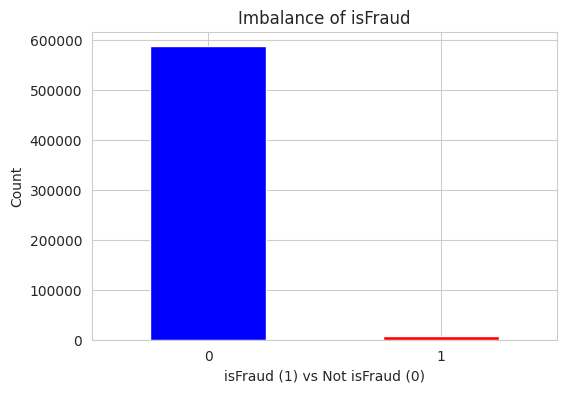

In [82]:
# plot imabalnce of target variable
eda = EDA(df_processed)
eda.plot_imbalance('isFraud')

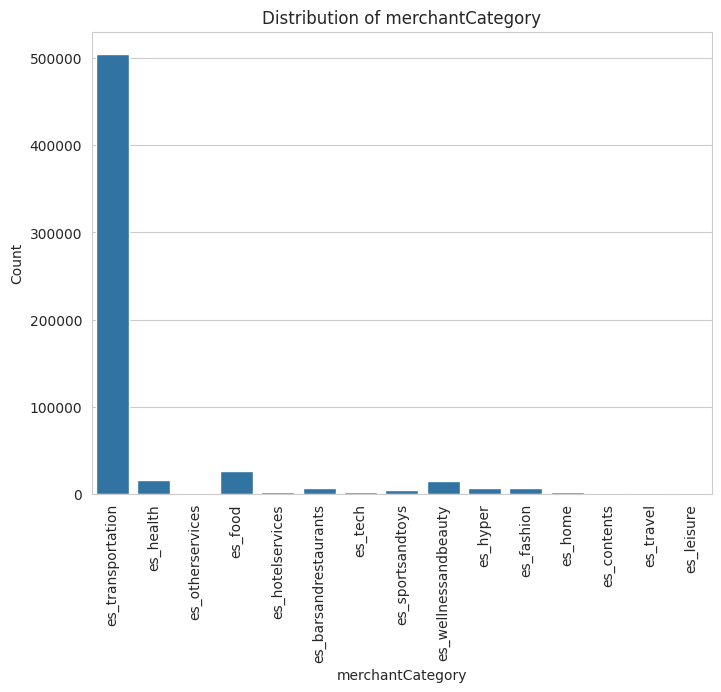

In [83]:
#Plot categorical distribution for merchantCategory column
eda.plot_categorical_distribution(df_processed, 'merchantCategory')

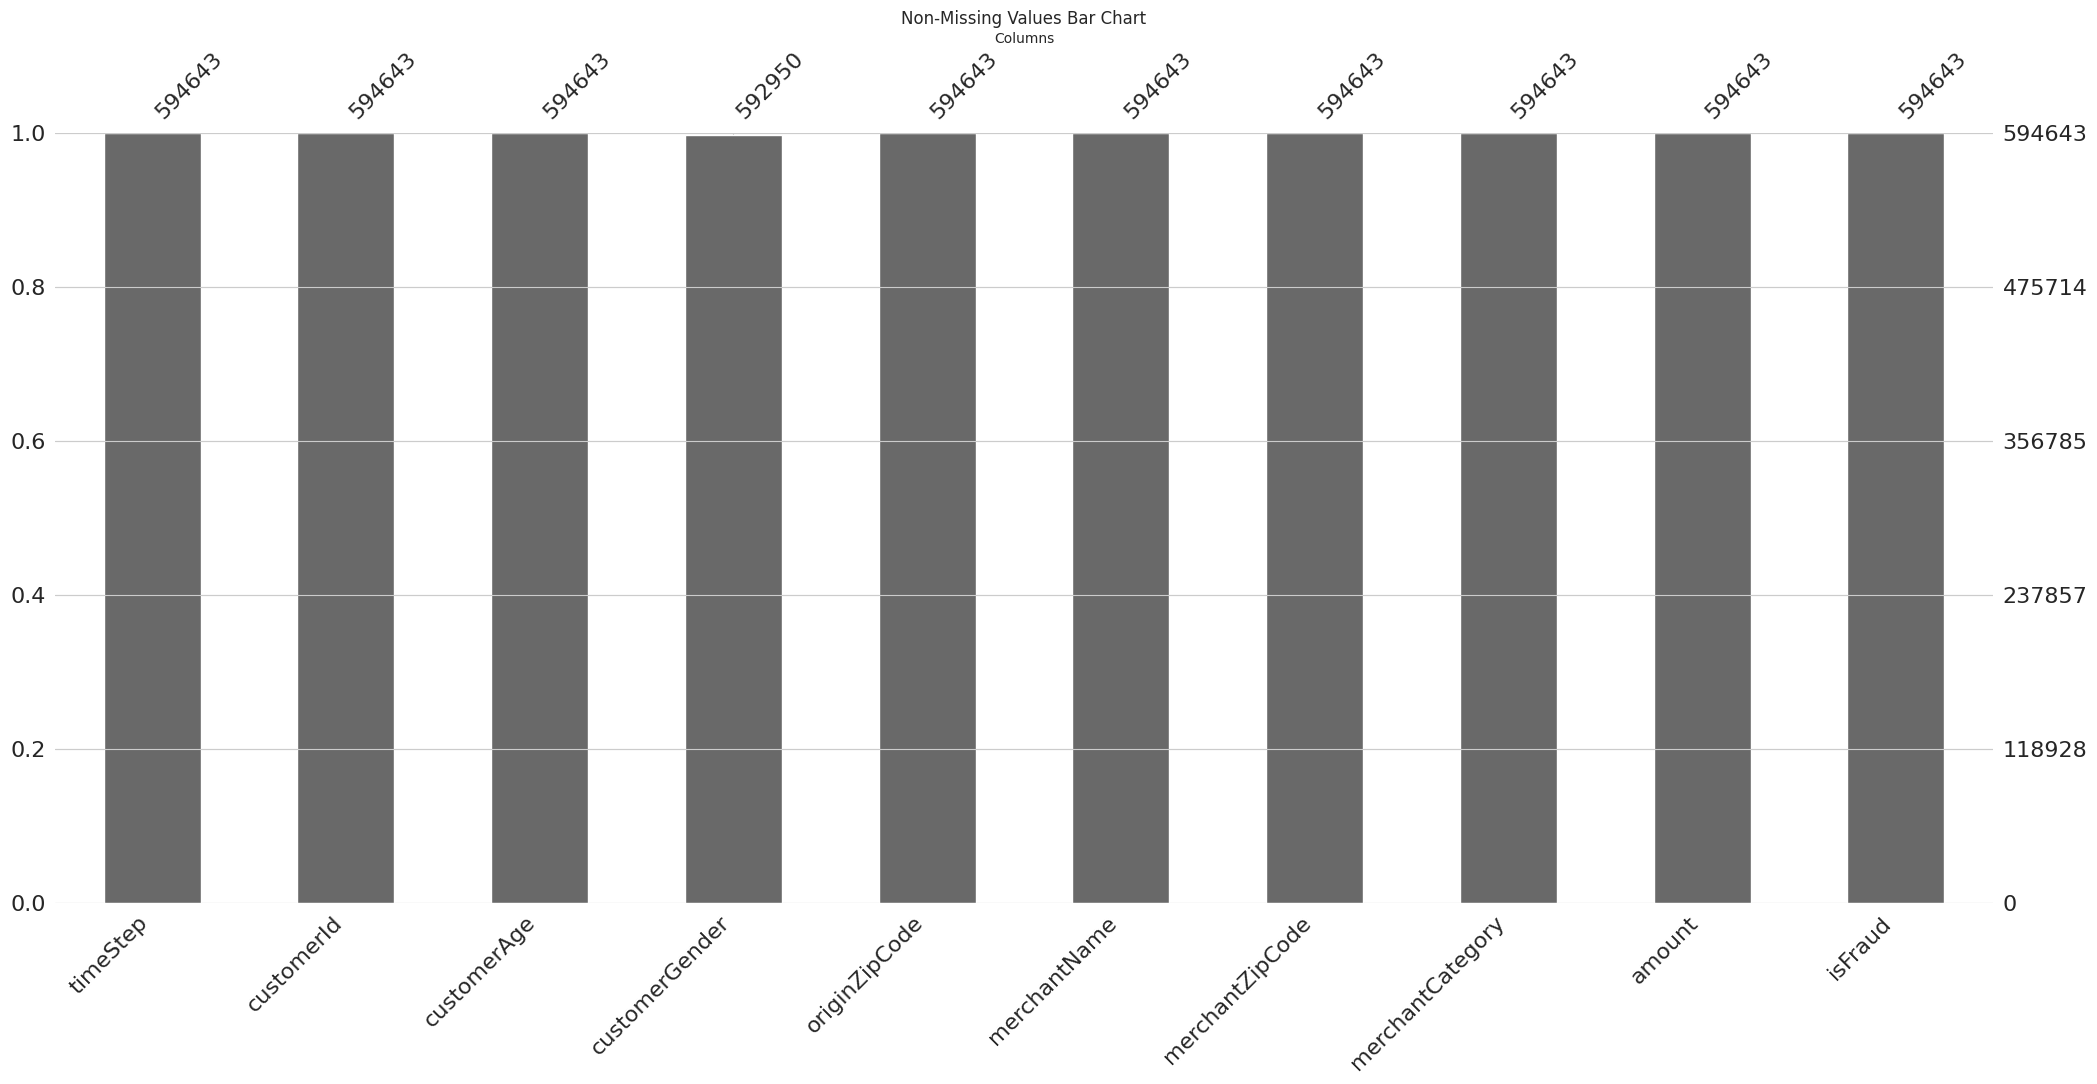

In [84]:
# Plot non-missing values in the given DataFrame using a bar chart
eda.plot_missing_values_bar(df_processed)

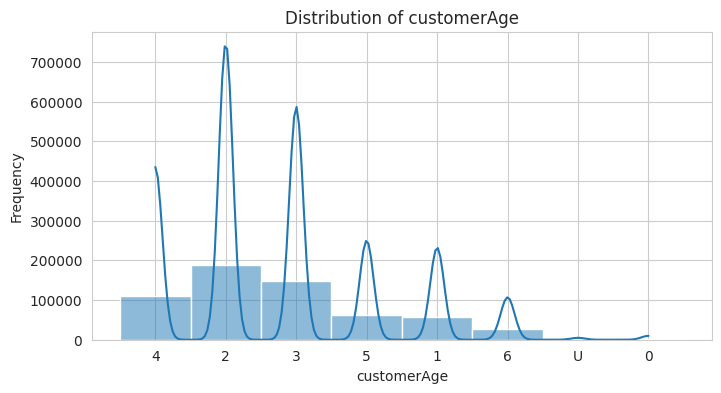

In [85]:
#Plot the distribution of customer age
eda.plot_customer_age_and_gender_distribution(df_processed, 'customerAge')

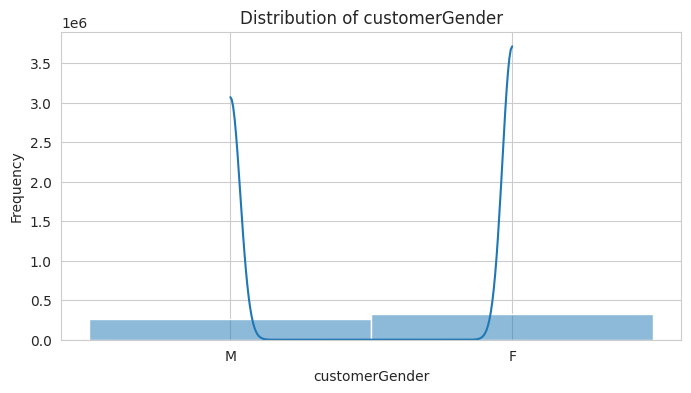

In [86]:
#Plot the distribution of customer gender
eda.plot_customer_age_and_gender_distribution(df_processed, 'customerGender')

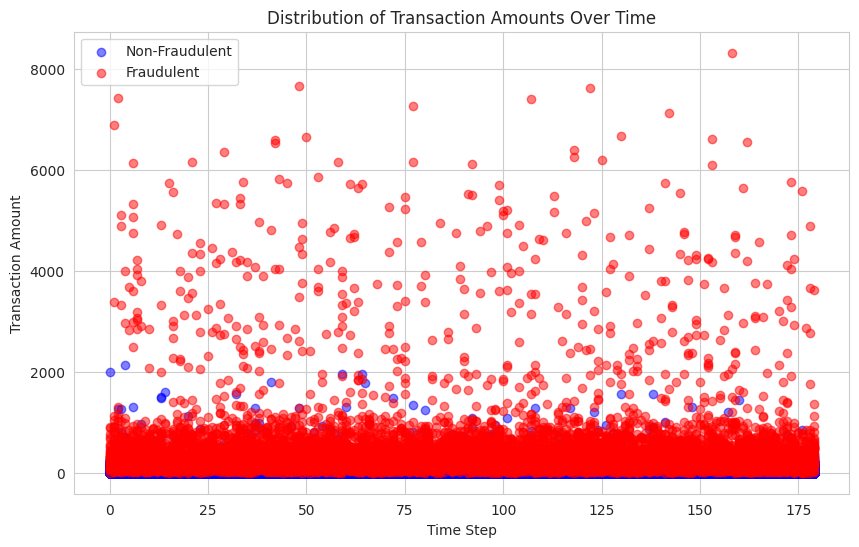

In [87]:
eda.plot_amount_distribution(df_processed)

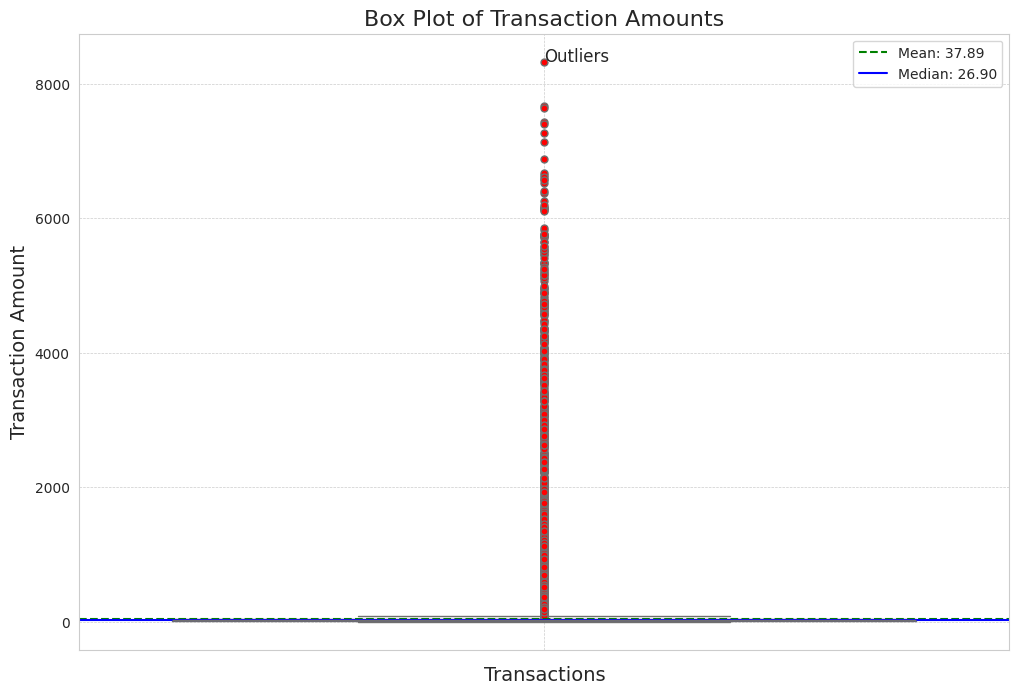

In [88]:
eda.plot_amount_boxplot(df_processed)

EDA for fraudlent transactions

In [90]:
df_fraud_trx = df_processed[df_processed['isFraud'] == 1]

In [91]:
edaFraud = EDA(df_fraud_trx)

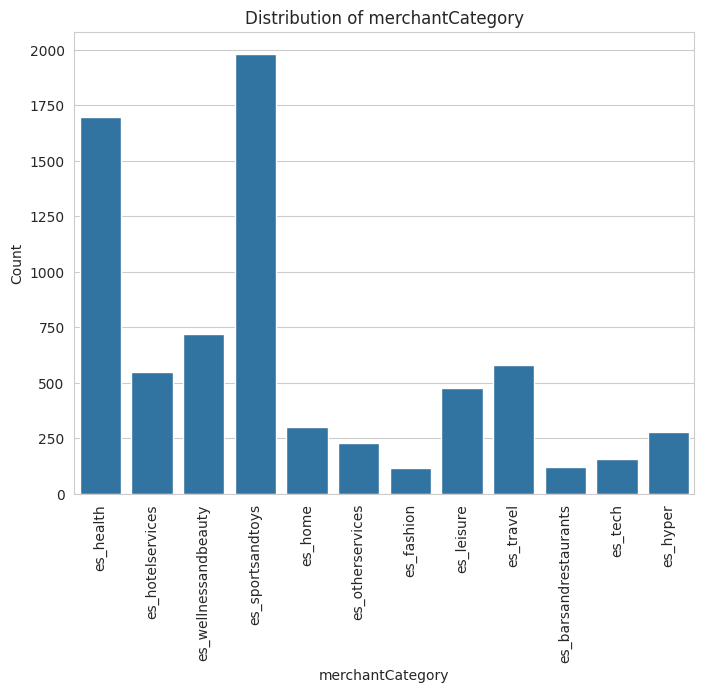

In [92]:
#Plot categorical distribution for merchantCategory column
edaFraud.plot_categorical_distribution(df_fraud_trx, 'merchantCategory')

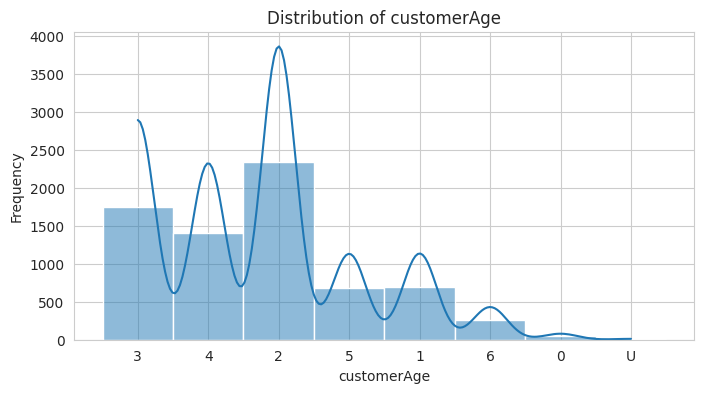

In [93]:
#Plot the distribution of customer age
edaFraud.plot_customer_age_and_gender_distribution(df_fraud_trx, 'customerAge')

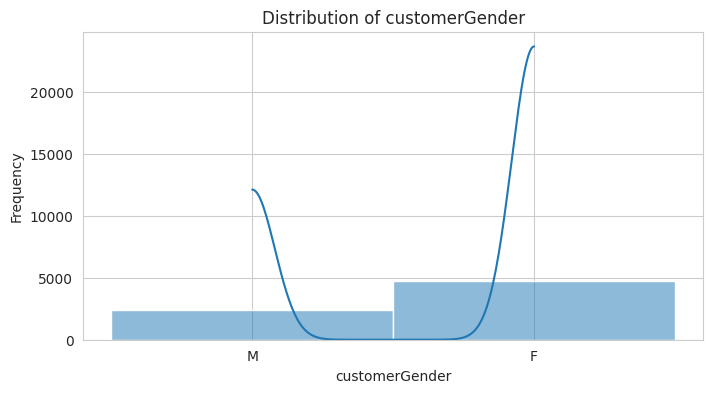

In [94]:
#Plot the distribution of customer gender
edaFraud.plot_customer_age_and_gender_distribution(df_fraud_trx, 'customerGender')

### More pre-processing to handle categorical values

In [101]:
# Convert categorical column to category codes
df_processed = data_preprocessor.convert_to_category_codes(df_processed, 'merchantCategory')
df_processed = data_preprocessor.convert_to_category_codes(df_processed, 'customerGender')

In [102]:
df_processed

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud
0,0,C1093826151,4,1,28007,M348934600,28007,12,4.55,0
1,0,C352968107,2,1,28007,M348934600,28007,12,39.68,0
2,0,C2054744914,4,0,28007,M1823072687,28007,12,26.89,0
3,0,C1760612790,3,1,28007,M348934600,28007,12,17.25,0
4,0,C757503768,5,1,28007,M348934600,28007,12,35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,0,28007,M1823072687,28007,12,20.53,0
594639,179,C650108285,4,0,28007,M1823072687,28007,12,50.73,0
594640,179,C123623130,2,0,28007,M349281107,28007,2,22.44,0
594641,179,C1499363341,5,1,28007,M1823072687,28007,12,14.46,0


### Handling Dataset Imbalance